In [9]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import os

import librosa as l
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn

# Keras
import keras
import keras_metrics
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop

In [10]:
#%pip install keras_metrics

In [11]:
final_df = pd.read_csv('../Datasets/aug_final_df.csv')

# drop first column
#final_df.drop('Unnamed: 0', axis='columns', inplace=True)

# train-test split dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

final_df_testing = final_df.copy()
final_df_testing = shuffle(final_df_testing)

X = final_df_testing.drop(columns=['Path', 'Emotions'], axis=1)
y = final_df_testing['Emotions']
print(X.shape, y.shape)

(11682, 173) (11682,)


In [12]:
# Handle imbalance classes with SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

print('Original dataset shape', Counter(y))
print('\n')
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 1096, 3: 1096, 2: 1096, 4: 1096, 6: 1096, 5: 960, 10: 767, 11: 767, 14: 767, 8: 767, 12: 767, 13: 623, 7: 496, 15: 96, 9: 96, 1: 96})


Resample dataset shape Counter({0: 1096, 3: 1096, 10: 1096, 7: 1096, 13: 1096, 2: 1096, 15: 1096, 4: 1096, 11: 1096, 14: 1096, 5: 1096, 6: 1096, 8: 1096, 12: 1096, 9: 1096, 1: 1096})


In [13]:
X_train

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,Mel124,Mel125,Mel126,Mel127,Tonnetz0,Tonnetz1,Tonnetz2,Tonnetz3,Tonnetz4,Tonnetz5
4216,-365.801444,49.798318,15.550155,-4.362838,-4.021952,4.349767,-6.922862,-6.326784,-10.398674,-6.494148,...,0.000411,0.000344,0.000221,0.000141,0.083590,-0.019060,-0.036506,0.119230,0.030633,-0.035740
13474,-328.068825,65.327872,32.034110,24.532756,7.000142,-2.432405,-5.484751,-3.738093,-2.130720,-2.551263,...,0.000320,0.000312,0.000311,0.000303,0.026641,0.010712,-0.016192,-0.050845,0.008021,-0.005160
2344,-463.768601,49.315008,16.499245,11.834983,13.627479,3.192552,-5.735217,-1.277034,-7.455479,-10.028136,...,0.000046,0.000037,0.000029,0.000018,-0.021354,-0.227198,-0.037016,-0.349207,0.016258,0.118888
15889,-400.811167,96.745469,48.923668,35.674330,10.487492,4.689811,-4.443645,-2.568535,-3.984920,-1.574230,...,0.000031,0.000032,0.000030,0.000030,0.025333,-0.013397,-0.075293,-0.018707,0.019230,0.018150
15538,-370.069985,25.015778,0.395214,2.359637,-0.176661,-4.214380,-6.555327,-7.973824,-9.829360,-5.055727,...,0.000562,0.000396,0.000308,0.000207,-0.018247,0.010794,-0.001766,0.011203,-0.001502,-0.004783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-340.125638,51.994698,5.675900,-14.795871,-5.789765,-4.917576,-6.236856,-1.642727,-8.456881,-8.553480,...,0.000690,0.000542,0.000379,0.000170,0.055791,-0.015972,0.063367,-0.087922,0.025003,-0.007691
11964,-545.384482,22.282738,1.631686,3.485963,-2.657406,-3.129972,-4.711355,-6.062489,-6.239151,-3.398902,...,0.000014,0.000016,0.000017,0.000007,0.018500,0.005813,0.009967,-0.001135,0.016437,-0.009535
5390,-561.175287,16.494315,5.693257,0.902965,0.016026,-4.123977,-7.275866,-7.795027,-5.433545,-3.789624,...,0.000048,0.000032,0.000016,0.000007,-0.031438,-0.026064,0.007741,-0.019758,-0.006125,-0.008076
860,-289.163149,77.986326,28.419738,20.525965,2.838654,-9.565187,-2.270251,-2.631699,-7.091905,-1.009537,...,0.000539,0.000533,0.000543,0.000521,-0.015458,0.032533,-0.037320,0.014715,0.023949,0.032739


In [23]:
model = tf.keras.Sequential()

model.add(layers.Conv1D(128, kernel_size=5, strides=1, # first convulational layer
                        padding="same", activation="relu",
                        input_shape=(X_smote.shape[1], 1))) 
model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,  # second convulational layer
                        padding="same", activation="relu"))
model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Flatten()) # flatten into a 1D array
model.add(layers.Dense(128, activation='relu')) # fully connected layer
model.add(layers.Dense(64, activation='relu')) # fully connected layer

model.add(layers.Dense(16, activation="softmax")) # output layer

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 173, 128)          768       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 87, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 87, 256)           164096    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 44, 256)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 11264)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [24]:
# Compile the model with appropriate Loss function
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

#sparse_categorical_crossentropy --> when targets are integer & suitable for multiclasses
#categorical_crossentropy --> when targets are one-hot encoded vectors (binary) 

In [25]:
epochs = 200
 
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test)) 

Epoch 1/200
439/439 [==============================] - 22s 51ms/step - loss: 2.1312 - accuracy: 0.3290 - val_loss: 1.8975 - val_accuracy: 0.4031
Epoch 2/200
439/439 [==============================] - 23s 52ms/step - loss: 1.7529 - accuracy: 0.4562 - val_loss: 1.7108 - val_accuracy: 0.4621
Epoch 3/200
439/439 [==============================] - 22s 51ms/step - loss: 1.5754 - accuracy: 0.5053 - val_loss: 1.5738 - val_accuracy: 0.4923
Epoch 4/200
439/439 [==============================] - 22s 50ms/step - loss: 1.4002 - accuracy: 0.5515 - val_loss: 1.4139 - val_accuracy: 0.5268
Epoch 5/200
439/439 [==============================] - 22s 50ms/step - loss: 1.3081 - accuracy: 0.5674 - val_loss: 1.2792 - val_accuracy: 0.5710
Epoch 6/200
439/439 [==============================] - 21s 48ms/step - loss: 1.2196 - accuracy: 0.5896 - val_loss: 1.2915 - val_accuracy: 0.5764
Epoch 7/200
439/439 [==============================] - 21s 49ms/step - loss: 1.1805 - accuracy: 0.6008 - val_loss: 1.2762 - val_ac

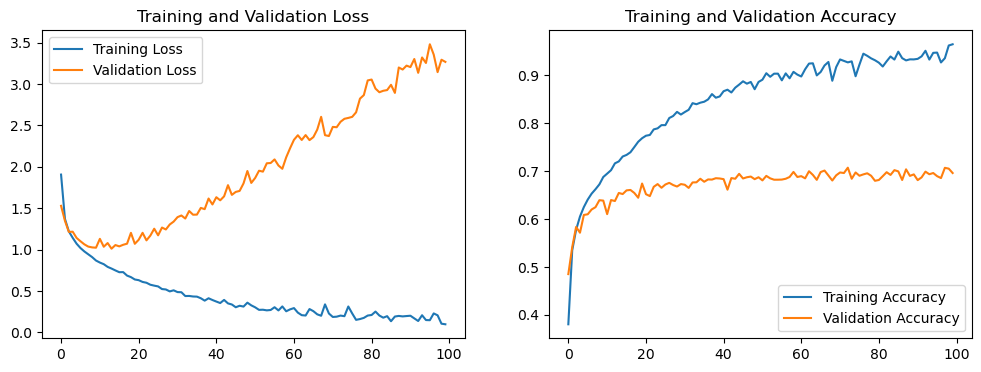

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions and calculate metrics
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

print("\n")

# For a detailed classification report including precision, recall, f1-score per class
print(classification_report(y_test, predicted_classes))

110/110 [==============================] - 1s 6ms/step
Precision: 0.7077795268227172, Recall: 0.7021094640820981, F1-Score: 0.7007579936473332


              precision    recall  f1-score   support

           0       0.72      0.72      0.72       214
           1       0.92      1.00      0.96       216
           2       0.62      0.54      0.57       221
           3       0.74      0.58      0.65       252
           4       0.63      0.63      0.63       210
           5       0.76      0.66      0.71       242
           6       0.55      0.74      0.63       212
           7       0.95      0.98      0.97       213
           8       0.75      0.61      0.67       227
           9       0.96      0.97      0.96       207
          10       0.54      0.55      0.54       229
          11       0.54      0.54      0.54       235
          12       0.56      0.56      0.56       232
          13       0.65      0.53      0.58       203
          14       0.52      0.75      0.61 